# XOR classification problem

In [239]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch

In [240]:
torch.manual_seed(0)
np.random.seed(0)

x = np.random.uniform(low=-1, high=1, size=(200, 2))
y = np.ones(x.shape[0])
y[x[:,0] * x[:,1] < 0] = 0

x.shape, y.shape

((200, 2), (200,))

In [241]:
# Get train and validation subsets (half the sample)

# Train (first half)
x_train = torch.tensor(x[:100, :], dtype=torch.float)
y_train = torch.tensor(y[:100], dtype=torch.float)

# Valid (second half)
x_valid = torch.tensor(x[100:, :], dtype=torch.float)
y_valid = torch.tensor(y[100:], dtype=torch.float)


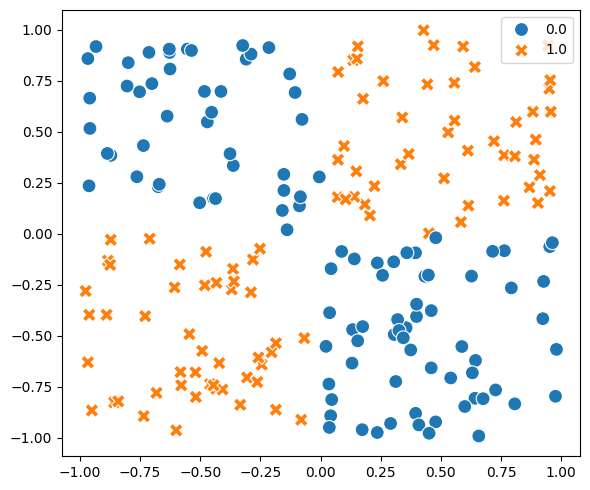

In [242]:
plt.figure(figsize=(6,5))
sns.scatterplot(x=x[:,0], y=x[:,1], hue=y, s=100, legend=True, style=y, markers=['o', 'X'])
plt.tight_layout()

#### We're gonna start with a simple model as a baseline:

In [243]:
# single layer NN, like logistic regression:
model = torch.nn.Sequential(
    torch.nn.Linear(2,1), # 2 in features: x[0], x[1]; 1 out class: 0/1
    torch.nn.Sigmoid()
)
model

Sequential(
  (0): Linear(in_features=2, out_features=1, bias=True)
  (1): Sigmoid()
)

In [244]:
# initialize cross-entropy loss function (log loss, the one used in logistic reg) for binary classification,
# and the SGD optimizer

loss_fn = torch.nn.BCELoss()

optimizer = torch.optim.SGD(model.parameters(),
                            lr=0.001)

In [245]:
from torch.utils.data import TensorDataset, DataLoader

In [246]:
# dataloader with batch-size = 2
train_ds = TensorDataset(x_train, y_train)
batch_size = 2
torch.manual_seed(0)
train_dl = DataLoader(train_ds,
                      batch_size=batch_size,
                      shuffle=True)

In [247]:
# now train model, with 200 epochs and history
n_epochs = 200
torch.manual_seed(0)

def train(model, n_epochs, train_dl, x_valid, y_valid):
    loss_hist_train = [0] * n_epochs
    acc_hist_train = [0] * n_epochs
    loss_hist_valid = [0] * n_epochs
    acc_hist_valid = [0] * n_epochs
    for epoch in range(n_epochs):
        for x_batch, y_batch in train_dl:
            pred = model(x_batch)[:,0] # output [[y],[y]] -> [y,y]
            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_hist_train[epoch] += loss.item()
            is_correct =  ((pred>=0.5).float() == y_batch).float()
            acc_hist_train[epoch] += is_correct.mean()
        loss_hist_train[epoch] /= len(x_train)
        acc_hist_train[epoch] /= len(x_train)/batch_size
        pred = model(x_valid)[:,0]
        loss = loss_fn(pred, y_valid)
        loss_hist_valid[epoch] = loss.item()
        is_correct = ((pred>=0.5).float() == y_valid).float()
        acc_hist_valid[epoch] += is_correct.mean()
        
    return loss_hist_train, loss_hist_valid, acc_hist_train, acc_hist_valid

In [248]:
history = train(model, n_epochs, train_dl, x_valid, y_valid)

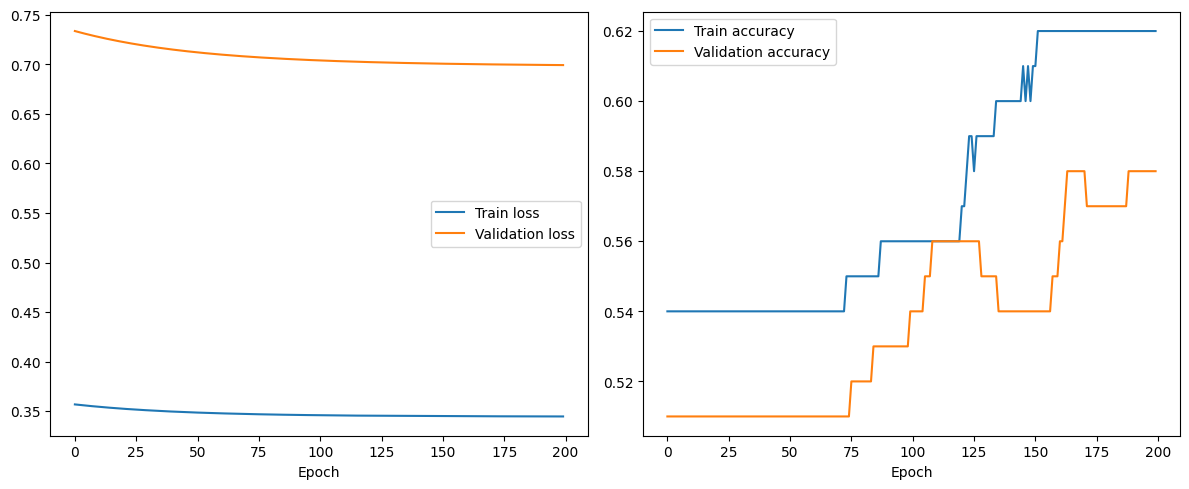

In [249]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(12,5))

ax[0].plot(history[0])
ax[0].plot(history[1])
ax[0].legend(['Train loss', 'Validation loss'])
ax[0].set_xlabel('Epoch')

ax[1].plot(history[2])
ax[1].plot(history[3])
ax[1].legend(['Train accuracy', 'Validation accuracy'])
ax[1].set_xlabel('Epoch')

plt.tight_layout()

A simple model with no hidden layer can only derive a linear decision boundary, which is unable to solve the XOR problem, giving poor performance results.  

To derive a nonlinear decision boundary, we can add one or more hidden layers connected via nonlinear activation functions, which will make the model deeper. The advantage of making a network deeper rather than wider (more hidden units in a single hidden layer) is that fewer parameters are required to achieve a comparable model capacity. However, a downside of deep (versus wide) models is that deep models are prone to vanishing and exploding gradients, which make them harder to train

#### Now we will try adding with 2 hidden layers:

In [297]:
model = torch.nn.Sequential(
    torch.nn.Linear(2,4),
    torch.nn.ReLU(),
    torch.nn.Linear(4,4),
    torch.nn.ReLU(),
    torch.nn.Linear(4,1),
    torch.nn.Sigmoid()
)

loss_fn = torch.nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.075)
model

Sequential(
  (0): Linear(in_features=2, out_features=4, bias=True)
  (1): ReLU()
  (2): Linear(in_features=4, out_features=4, bias=True)
  (3): ReLU()
  (4): Linear(in_features=4, out_features=1, bias=True)
  (5): Sigmoid()
)

In [298]:
history = train(model, n_epochs, train_dl, x_valid, y_valid)

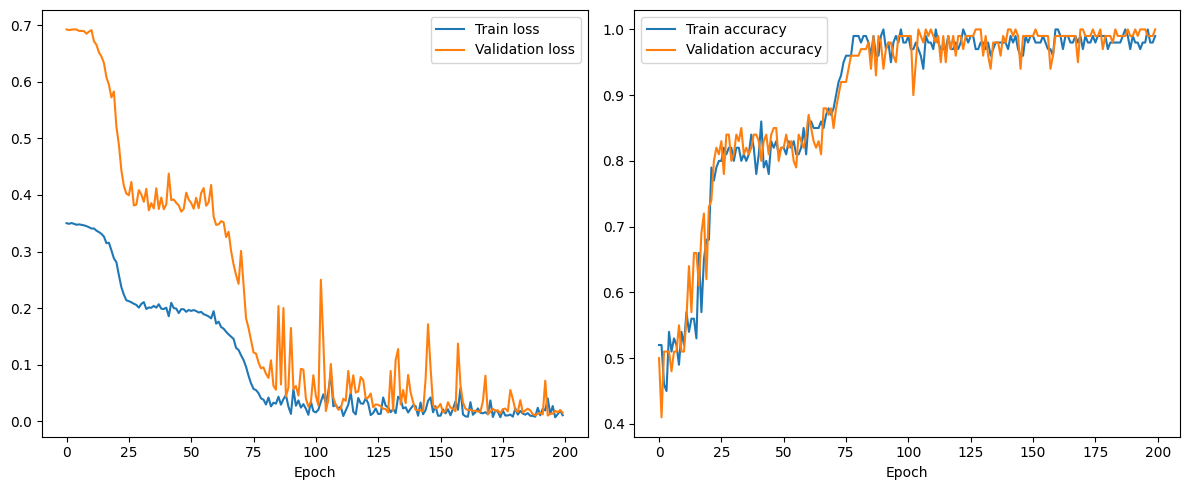

In [299]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(12,5))

ax[0].plot(history[0])
ax[0].plot(history[1])
ax[0].legend(['Train loss', 'Validation loss'])
ax[0].set_xlabel('Epoch')

ax[1].plot(history[2])
ax[1].plot(history[3])
ax[1].legend(['Train accuracy', 'Validation accuracy'])
ax[1].set_xlabel('Epoch')

plt.tight_layout()

In [296]:
print(f'Traning accuracy after {n_epochs} epochs: {history[2][-1]}\n'
      f'Validation accuracy after {n_epochs} epochs: {history[3][-1]}')

Traning accuracy after 200 epochs: 0.9900000095367432
Validation accuracy after 200 epochs: 1.0


Now, we can see that the model is able to derive a nonlinear decision boundary for this data, and it reaches almost 100 percent accuracy.


#### Making it more flexible

In [300]:
import torch.nn as nn

In [ ]:
class MyModule(nn.Module):
    def __init__(self):
        super().__init__()
        l1 = nn.Linear(2, 4)
        a1 = nn.ReLU()
        l2 = nn.Linear(4, 4)
        a2 = nn.ReLU()
        l3 = nn.Linear(4, 1)
        a3 = nn.Sigmoid()
        l = [l1, a1, l2, a2, l3, a3]
        self.module_list = nn.ModuleList(l)
    
    def forward(self, x):
        for f in self.module_list:
            x = f(x)
        return x
    
    def predict(self, x):
        x = torch.tensor(x, dtype=torch.float)
        pred = self.forward(x)[:,0]
        return (pred>=0.5).float()

We can train this model with the same training function as before.